In [1]:
import os
import sys

if "COLAB_GPU" in os.environ:
  from google.colab import drive
  print("Hello, Colab")
  drive.mount("/content/drive")
  ROOT_PATH = "/content/drive/MyDrive/hero"
  os.environ["CLEARML_CONFIG_FILE"] = f"{ROOT_PATH}/clearml.conf"
elif "PAPERSPACE_CLUSTER_ID" in os.environ:
  print("Hello, Paperspace")
  ROOT_PATH = "/notebooks/hero"
  os.environ["CLEARML_CONFIG_FILE"] = f"{ROOT_PATH}/clearml.conf"
else:
  ROOT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))

# we'll use artifacts from previous experiment
EXPERIMENT_PATH = f"{ROOT_PATH}/experiments/tcnn-abilities"
ARTIFACTS_PATH = f"{EXPERIMENT_PATH}/artifacts"
sys.path.insert(0, ROOT_PATH)

In [2]:
from collections import defaultdict
from json import load, dumps, dump
from itertools import product

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr
import torch
import torch.nn as nn

from torch.utils.data import DataLoader

from src.models import binary_tree_layers as btl
from src.models.regressor import BinaryTreeRegressor
from src.datasets.oracle import Oracle, OracleRequest, TIMEOUT
from src.datasets.data_config import HINTSETS, DOPS, HINTS, DEFAULT_HINTSET
from src.datasets.data_types import ExplainNode
from src.datasets.vectorization import extract_vertices_and_edges, ALL_FEATURES
from src.datasets.binary_tree_dataset import binary_tree_collate, BinaryTreeDataset, WeightedBinaryTreeDataset, weighted_binary_tree_collate, paddify_sequences
from src.utils import get_structure, get_tree, preprocess, featurize_dataset, filter_df, load_run

# Loading data

In [3]:
job_oracle = Oracle(f"{ROOT_PATH}/data/processed/JOB")
sq_oracle = Oracle(f"{ROOT_PATH}/data/processed/sample_queries")

In [4]:
job_list_info = torch.load(f"{ARTIFACTS_PATH}/job_list_info")
ood_sq_list_info = torch.load(f"{ARTIFACTS_PATH}/ood_sq_list_info")
id_sq_list_info = torch.load(f"{ARTIFACTS_PATH}/id_sq_list_info")

In [5]:
job_list_vertices, job_list_edges, job_list_time = [[info[key] for info in job_list_info] for key in ["vertices", "edges", "time"]]        
ood_sq_list_vertices, ood_sq_list_edges, ood_sq_list_time = [[info[key] for info in ood_sq_list_info] for key in ["vertices", "edges", "time"]]
id_sq_list_vertices, id_sq_list_edges, id_sq_list_time = [[info[key] for info in id_sq_list_info] for key in ["vertices", "edges", "time"]]

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {DEVICE}")

device is cpu


In [7]:
# it'll be splitted correctly on train/val datasets` in `load_run`
TRAINVAL_DATASET = WeightedBinaryTreeDataset(job_list_vertices, job_list_edges, job_list_time, DEVICE)

TEST_DATASET = WeightedBinaryTreeDataset(id_sq_list_vertices, id_sq_list_edges, id_sq_list_time, DEVICE)
OOD_DATASET = WeightedBinaryTreeDataset(ood_sq_list_vertices, ood_sq_list_edges, id_sq_list_time, DEVICE)

# Model

In [11]:
in_channels = len(ALL_FEATURES)

big_btcnn_and_instance_norm = lambda: btl.BinaryTreeSequential(
    btl.BinaryTreeConv(in_channels, 64),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(64, 128),
    btl.BinaryTreeInstanceNorm(128),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(128, 256),
    btl.BinaryTreeInstanceNorm(256),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(256, 512),
    btl.BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_fcnn = lambda: torch.nn.Sequential(
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 1),
    nn.Softplus(),
)

In [12]:
def load_model(run, device):
    ckpt_path=f"{EXPERIMENT_PATH}/models/BigBTCNN_BigFCNN_InstanceNorm_{run}.pth"
    ckpt_state = torch.load(ckpt_path, map_location=device)
    model = BinaryTreeRegressor(big_btcnn_and_instance_norm(), big_fcnn())
    model.load_state_dict(ckpt_state["model_state_dict"])
    model = model.to(device)
    return model

In [13]:
def get_prediction(v, e, model):
    v, e = preprocess(v, e)
    return model(v.unsqueeze(0), e.unsqueeze(0)).squeeze(0).item()

In [14]:
def predict(v, e, cache, model):
    v, e = preprocess(v, e)
    ve = str(v.flatten().tolist()), str(e.flatten().tolist())
    if ve in cache:
        return cache[ve]
    else:
        prediction = model(v.unsqueeze(0), e.unsqueeze(0)).squeeze(0).item()
        cache[ve] = prediction
        return prediction

# Building maps [$\langle v, e\rangle \rightarrow costs$] and [$\langle v, e\rangle \rightarrow times$]

We can only recover splitted data **after** grouping, because of this we have to somehow recover both real labels (`time`) and predictions of the default model (`cost`) by `vertices` and `edges`.

In [15]:
JOB_VE_TO_COSTS = defaultdict(list)
JOB_VE_TO_TIMES = defaultdict(list)
for info in job_list_info:
    v, e, t = info["vertices"], info["edges"], info["time"]
    v, e = preprocess(v, e)
    ve = str(v.flatten().tolist()), str(e.flatten().tolist())
    cost = job_oracle.get_cost(OracleRequest(query_name=info["query_name"], hintset=info["hintset"], dop=info["dop"]))
    JOB_VE_TO_COSTS[ve].append(cost)
    JOB_VE_TO_TIMES[ve].append(t.item())

In [16]:
SQ_VE_TO_COSTS = defaultdict(list)
SQ_VE_TO_TIMES = defaultdict(list)
for info in id_sq_list_info + ood_sq_list_info:
    v, e, t = info["vertices"], info["edges"], info["time"]
    v, e = preprocess(v, e)
    ve = str(v.flatten().tolist()), str(e.flatten().tolist())
    cost = sq_oracle.get_cost(OracleRequest(query_name=info["query_name"], hintset=info["hintset"], dop=info["dop"]))
    SQ_VE_TO_COSTS[ve].append(cost)
    SQ_VE_TO_TIMES[ve].append(t.item())

# Ranking metrics

Here we look at whether the order induced by the NN predictions is better than the order predicted by the default cost model.

## Stratified

Here we are going to calculate metrics on different strats of data to confirm our previous hypotheses about useful structure in the data for good generalisation.

In [14]:
def get_featurized_df(run):
    model, train_dataset, val_dataset = load_run(
        run=run,
        trainval_dataset=TRAINVAL_DATASET, 
        model=BinaryTreeRegressor(big_btcnn_and_instance_norm(), big_fcnn()), 
        ckpt_path=f"{EXPERIMENT_PATH}/models/BigBTCNN_BigFCNN_InstanceNorm_{run}.pth",
        device=DEVICE,     
    )

    train_structures = {get_structure(*preprocess(v, e)) for v, e, *_ in train_dataset}
    train_trees = {get_tree(*preprocess(v, e)) for v, e, *_ in train_dataset}

    datasets = (
        featurize_dataset(dataset, model, train_structures, train_trees, data_type) 
        for dataset, data_type in zip([train_dataset, val_dataset, TEST_DATASET, OOD_DATASET], ["train", "val", "test", "ood"])
    )
    return pd.concat(datasets, ignore_index=True)

In [15]:
def get_metrics(df):
    costs_map = JOB_VE_TO_COSTS if "train" in df["data_type"].values or "val" in df["data_type"].values else SQ_VE_TO_COSTS
    times_map = JOB_VE_TO_TIMES if "train" in df["data_type"].values or "val" in df["data_type"].values else SQ_VE_TO_TIMES
    
    costs, times, predictions = [], [], []
    for _, (v, e, p) in df[["vertices", "edges", "prediction"]].iterrows():
        v, e = preprocess(v, e)
        ve = str(v.flatten().tolist()), str(e.flatten().tolist())
        assert ve in costs_map and ve in times_map and len(costs_map[ve]) == len(times_map[ve])
        for cost, time in zip(costs_map[ve], times_map[ve]):
            costs.append(cost), times.append(time), predictions.append(p)    
    return kendalltau(times, costs)[0], kendalltau(times, predictions)[0], spearmanr(times, costs)[0], spearmanr(times, predictions)[0]

In [16]:
def metrics_to_row(metrics):
    pm = u"\u00B1"
    return f"{np.nanmean(metrics):0.3f}{pm}{np.nanstd(metrics):0.3f}"

In [17]:
def calculate_stratified_metrics(n_runs=5):
    res = defaultdict(list)
    for run in range(1, n_runs+1):
        df = get_featurized_df(run=run)
        parameters = product(
            ["train", "val", "test", "ood"],
            ["all", "seen", "unseen"],
            ["all", "seen", "unseen"],
            ["all", "small", "medium", "big"],
            ["all", "underestimated", "overestimated"]
        )        
        for data_type, structure, tree, time, prediction in parameters:
            filtered_df = filter_df(df, {
                "data_type": data_type,
                "structure": structure,
                "tree": tree,
                "time": time,
                "prediction": prediction
            })        
            size = int(filtered_df["frequency"].sum())
            metrics = get_metrics(filtered_df)
            res[(data_type, structure, tree, time, prediction)].append((size, *metrics))              
    return res

In [18]:
def aggregate_metrics_dict(metrics_dict, runs_range):
    aggregated_list = [
        (
            data_type, structure, tree, time, prediction, 
            int(np.mean([metrics_dict[key][run-1][0] for run in runs_range])), 
            metrics_to_row([metrics_dict[key][run-1][1] for run in runs_range]),
            metrics_to_row([metrics_dict[key][run-1][2] for run in runs_range]),
            metrics_to_row([metrics_dict[key][run-1][3] for run in runs_range]),
            metrics_to_row([metrics_dict[key][run-1][4] for run in runs_range])
        )
        for key in metrics_dict
        for data_type, structure, tree, time, prediction in [key]
    ]

    return pd.DataFrame(
        aggregated_list, 
        columns=[
            "data_type", 
            "structure_category", 
            "tree_category", 
            "time_category", 
            "prediction_category", 
            "size", 
            "Kendall [c]", 
            "Kendall [p]", 
            "Spearman [c]", 
            "Spearman [p]"
        ]
    )

In [19]:
def select_subdf(df, allowed_data_type_predicates=None, allowed_structure_predicates=None, allowed_tree_predicates=None, allowed_time_predicates=None, allowed_prediction_predicates=None):
    if allowed_data_type_predicates is None:
        allowed_data_type_predicates = ["train", "val", "test", "ood"]
    if allowed_structure_predicates is None:
        allowed_structure_predicates = ["seen", "unseen", "all"]        
    if allowed_tree_predicates is None:
        allowed_tree_predicates = ["seen", "unseen", "all"]                
    if allowed_time_predicates is None:
        allowed_time_predicates = ["big", "medium", "small", "all"]                
    if allowed_prediction_predicates is None:
        allowed_prediction_predicates = ["underestimated", "overestimated", "all"]                

    idx = (df["data_type"].isin(allowed_data_type_predicates))
    idx = idx & (df["structure_category"].isin(allowed_structure_predicates))
    idx = idx & (df["tree_category"].isin(allowed_tree_predicates))
    idx = idx & (df["time_category"].isin(allowed_time_predicates))
    idx = idx & (df["prediction_category"].isin(allowed_prediction_predicates))

    return df[idx]

In [ ]:
n_runs = 5
metrics_dict = calculate_stratified_metrics(n_runs)
metrics_df = aggregate_metrics_dict(metrics_dict,  range(1, n_runs+1))

In [21]:
select_subdf(metrics_df, ["train"], ["all"], ["all"], None, ["all"])

,data_type,structure_category,tree_category,time_category,prediction_category,size,Kendall [c],Kendall [p],Spearman [c],Spearman [p]
0,train,all,all,all,all,34914,0.199±0.005,0.895±0.007,0.277±0.008,0.974±0.003
3,train,all,all,small,all,8627,0.104±0.009,0.376±0.027,0.145±0.013,0.537±0.033
6,train,all,all,medium,all,17412,0.172±0.007,0.859±0.012,0.250±0.010,0.959±0.005
9,train,all,all,big,all,8875,0.121±0.007,0.930±0.005,0.179±0.010,0.985±0.003


In [22]:
select_subdf(metrics_df, ["val"], ["all"], ["all"], None, ["all"])

,data_type,structure_category,tree_category,time_category,prediction_category,size,Kendall [c],Kendall [p],Spearman [c],Spearman [p]
108,val,all,all,all,all,8477,0.153±0.024,0.723±0.019,0.213±0.034,0.865±0.016
111,val,all,all,small,all,1931,-0.002±0.047,0.196±0.065,-0.026±0.073,0.290±0.088
114,val,all,all,medium,all,4260,0.169±0.030,0.552±0.038,0.245±0.041,0.704±0.041
117,val,all,all,big,all,2286,0.095±0.026,0.598±0.031,0.145±0.035,0.720±0.035


In [23]:
select_subdf(metrics_df, ["test"], ["all"], ["all"], None, ["all"])

,data_type,structure_category,tree_category,time_category,prediction_category,size,Kendall [c],Kendall [p],Spearman [c],Spearman [p]
216,test,all,all,all,all,4992,0.061±0.000,0.856±0.009,0.076±0.000,0.954±0.006
219,test,all,all,small,all,1766,-0.044±0.000,0.394±0.026,-0.081±0.000,0.574±0.036
222,test,all,all,medium,all,1238,0.205±0.000,0.764±0.038,0.276±0.000,0.882±0.033
225,test,all,all,big,all,1988,0.148±0.000,0.895±0.011,0.195±0.000,0.967±0.010


In [24]:
select_subdf(metrics_df, ["ood"], ["all"], ["all"], None, ["all"])

,data_type,structure_category,tree_category,time_category,prediction_category,size,Kendall [c],Kendall [p],Spearman [c],Spearman [p]
324,ood,all,all,all,all,4992,0.091±0.000,0.221±0.034,0.133±0.000,0.322±0.049
327,ood,all,all,small,all,1553,0.136±0.000,0.253±0.031,0.194±0.000,0.369±0.045
330,ood,all,all,medium,all,1455,0.048±0.000,0.208±0.049,0.072±0.000,0.303±0.072
333,ood,all,all,big,all,1984,0.174±0.000,0.250±0.047,0.254±0.000,0.363±0.061


We see, that **all** the statements made earlier about the properties of generalisation ability are confirmed in terms of rank correlations. 

## Per-query

Here we will take into account one important detail - only candidates generated for the same query are compared during the planning, so it is natural to look at the average value of the metrics **separately** for each query.

Since the split was by **plans**, it is no longer possible to unambiguously define `train` / `val` metrics here, so let's consider three groups - `trainval` (`JOB`), `test`, `ood`.

In [25]:
def get_per_query_metrics(runs_range, list_info, oracle):
    metrics = []
    for run in runs_range:
        model = load_model(run, DEVICE)
        costs, predictions, times = defaultdict(list), defaultdict(list), defaultdict(list)
        
        for info in list_info:
            request = OracleRequest(query_name=info["query_name"], hintset=info["hintset"],dop=info["dop"])
            times[info["query_name"]].append(info["time"])
            predictions[info["query_name"]].append(get_prediction(info["vertices"], info["edges"], model))
            costs[info["query_name"]].append(oracle.get_cost(request))

        kendall_c, kendall_p, spearman_c, spearman_p = [], [], [], []
        for q_n in set(info["query_name"] for info in list_info):
            kendall_c.append(kendalltau(times[q_n], costs[q_n])[0])
            kendall_p.append(kendalltau(times[q_n], predictions[q_n])[0])
            spearman_c.append(spearmanr(times[q_n], costs[q_n])[0])
            spearman_p.append(spearmanr(times[q_n], predictions[q_n])[0])    
        
        metrics.append((np.nanmean(kendall_c), np.nanmean(kendall_p), np.nanmean(spearman_c), np.nanmean(spearman_p)))
    
    return (
        metrics_to_row([metrics[run-1][0] for run in runs_range]),
        metrics_to_row([metrics[run-1][1] for run in runs_range]),
        metrics_to_row([metrics[run-1][2] for run in runs_range]),
        metrics_to_row([metrics[run-1][3] for run in runs_range]),
    )

In [ ]:
metric_params = [
    ("trainval", job_list_info, job_oracle),
    ("test", id_sq_list_info, sq_oracle),
    ("ood", ood_sq_list_info, sq_oracle)
]

data = [(d, *get_per_query_metrics(range(1, 5+1), l, o)) for d, l, o in metric_params]
columns = ["data_type",  "Kendall [c]",  "Kendall [p]",  "Spearman [c]",  "Spearman [p]"]

per_query_metrics_df = pd.DataFrame(data, columns=columns)

In [28]:
per_query_metrics_df

,data_type,Kendall [c],Kendall [p],Spearman [c],Spearman [p]
0,trainval,0.435±0.000,0.634±0.010,0.585±0.000,0.765±0.010
1,test,0.468±0.000,0.588±0.005,0.615±0.000,0.724±0.006
2,ood,0.394±0.000,0.178±0.029,0.529±0.000,0.255±0.039


The per-query analysis confirmed our fears that generalisation on `ood` data might be quite **weak**. We saw that mse hardly dropped at all on `ood` data, and the current results also show us that in comparing an arbitrary pair of plans for specific queries, on average, the **cost model will perform better on `ood` data**.

However, it is worth noting that if we want to find just the **best** plans, the chosen metric may be **pessimistic** - it takes care of order recovery on bad plans as well, which we may not care about in some settings (depends on the use of the model). At the end of the notebook we will perform a generalisation analysis taking this observation into account. 

## On random data

We also made a number of conclusions about which features are the most useful for generalisation, using experiments on noised data. To support our hypotheses, let us compare the orders on the noisy data as well.

The key problem is that the training was performed on the noisy plans **after** the grouping. Thus, in addition to the complexity of getting the right `cost` by `vertices`, `edges`, we also need to get the right `vertices`, `edges` by `noise`. Due to the fact that noising and grouping of plans **didn't change plans order**, we still have the possibility to get all the necessary information.

In [29]:
def add_noise_to_vertices(v, channels, generator):
    noise = torch.rand(v.shape, device=v.device, generator=generator)
    res = v.clone()
    res[:,channels] = noise[:,channels]
    return res

In [30]:
class NoisedWeightedBinaryTreeDataset(WeightedBinaryTreeDataset):
    def __init__(
        self,
        list_vertices: "List[Tensor]",
        list_edges: "List[Tensor]",
        list_time: "List[Tensor]",
        device: "torch.device",
        noised_channels: "List[int]",  
        generator: "torch.Generator",
    ):
        super().__init__(list_vertices, list_edges, list_time, device)
        
        self.noised_channels = noised_channels

        # the only diff comparing to `training.ipynb`
        self.saved_vertices_ = [el.clone() for el in self.list_vertices]
        
        for i, v in enumerate(self.list_vertices):
            self.list_vertices[i] = add_noise_to_vertices(v, channels=self.noised_channels, generator=generator)

In [31]:
def load_noised_datasets(run, noised_channels):
    seed = 42 + run - 1
    generator = torch.Generator(device=DEVICE).manual_seed(seed)

    noised_trainval_dataset = NoisedWeightedBinaryTreeDataset(job_list_vertices, job_list_edges, job_list_time, DEVICE, noised_channels, generator)
    noised_test_dataset = NoisedWeightedBinaryTreeDataset(id_sq_list_vertices, id_sq_list_edges, id_sq_list_time, DEVICE, noised_channels, generator)
    noised_ood_dataset = NoisedWeightedBinaryTreeDataset(ood_sq_list_vertices, ood_sq_list_edges, ood_sq_list_time, DEVICE, noised_channels, generator)

    generator = torch.Generator().manual_seed(seed)
    noised_train_dataset, noised_val_dataset = torch.utils.data.dataset.random_split(noised_trainval_dataset, [0.8, 0.2], generator=generator)    
    
    return noised_train_dataset, noised_val_dataset, noised_test_dataset, noised_ood_dataset

In [32]:
def load_noised_model(run, mode, device):
    ckpt_path=f"{EXPERIMENT_PATH}/models/[{mode}] BigBTCNN_BigFCNN_InstanceNorm_{run}.pth"
    ckpt_state = torch.load(ckpt_path, map_location=device)
    model = BinaryTreeRegressor(big_btcnn_and_instance_norm(), big_fcnn())
    model.load_state_dict(ckpt_state["model_state_dict"])
    model = model.to(device)
    return model

In [51]:
def get_metrics_on_noised_dataset(dataset, model, costs_map, times_map):
    if hasattr(dataset, "indices"):
        indices, dataset = dataset.indices, dataset.dataset
    else:
        indices = range(len(dataset))

    costs, times, predictions = [], [], []
    for i in indices:
        v, e, real_v = dataset.list_vertices[i], dataset.list_edges[i], dataset.saved_vertices_[i]
        p = get_prediction(v, e, model)
        real_v, e = preprocess(real_v, e)
        ve = str(real_v.flatten().tolist()), str(e.flatten().tolist())
        assert ve in costs_map and len(costs_map[ve]) == len(times_map[ve])
        for cost, time in zip(costs_map[ve], times_map[ve]):
            costs.append(cost), times.append(time), predictions.append(p)   
             
    return kendalltau(times, costs)[0], kendalltau(times, predictions)[0], spearmanr(times, costs)[0], spearmanr(times, predictions)[0]

In [52]:
def get_metrics_on_noised_data(runs_range):
    metrics = defaultdict(list)
    noise_types = ["all", "stats", "ops"]
    list_noised_channels = [range(len(ALL_FEATURES)), range(len(ALL_FEATURES)-2, len(ALL_FEATURES)), range(len(ALL_FEATURES)-2)]
    for noise_type, noised_channels in zip(noise_types, list_noised_channels):
        for run in runs_range:
            data_types = ["train", "val", "test", "ood"]
            costs_maps = [JOB_VE_TO_COSTS, JOB_VE_TO_COSTS, SQ_VE_TO_COSTS, SQ_VE_TO_COSTS]
            times_maps = [JOB_VE_TO_TIMES, JOB_VE_TO_TIMES, SQ_VE_TO_TIMES, SQ_VE_TO_TIMES]
            model = load_noised_model(run, noise_type, DEVICE)
            for data_type, costs_map, times_map, dataset in zip(data_types, costs_maps, times_maps, load_noised_datasets(run, noised_channels)):
                metrics[data_type, noise_type].append(get_metrics_on_noised_dataset(dataset, model, costs_map, times_map))
    return metrics

In [53]:
def aggregate_noised_metrics_dict(noised_metrics_dict, runs_range):
    aggregated_list = [
        (
            data_type, noise_type, 
            metrics_to_row([noised_metrics_dict[key][run-1][0] for run in runs_range]),
            metrics_to_row([noised_metrics_dict[key][run-1][1] for run in runs_range]),
            metrics_to_row([noised_metrics_dict[key][run-1][2] for run in runs_range]),
            metrics_to_row([noised_metrics_dict[key][run-1][3] for run in runs_range])
        )
        for key in noised_metrics_dict for (data_type, noise_type) in [key]
    ]
    return pd.DataFrame(aggregated_list, columns=["data_type",  "noise_type",  "Kendall [c]",  "Kendall [p]", "Spearman [c]", "Spearman [p]"])

In [54]:
runs_range = range(1, 5+1)
noised_metrics_dict = get_metrics_on_noised_data(runs_range)
noised_metrics_df = aggregate_noised_metrics_dict(noised_metrics_dict, runs_range)

In [55]:
noised_metrics_df[noised_metrics_df["noise_type"] == "ops"]

,data_type,noise_type,Kendall [c],Kendall [p],Spearman [c],Spearman [p]
8,train,ops,0.199±0.005,0.558±0.022,0.277±0.008,0.731±0.023
9,val,ops,0.153±0.024,0.496±0.021,0.213±0.034,0.665±0.024
10,test,ops,0.061±0.000,0.573±0.020,0.076±0.000,0.757±0.021
11,ood,ops,0.161±0.000,0.143±0.021,0.242±0.000,0.210±0.032


In [56]:
noised_metrics_df[noised_metrics_df["noise_type"] == "stats"]

,data_type,noise_type,Kendall [c],Kendall [p],Spearman [c],Spearman [p]
4,train,stats,0.199±0.005,0.338±0.009,0.277±0.008,0.476±0.013
5,val,stats,0.153±0.024,0.280±0.018,0.213±0.034,0.401±0.026
6,test,stats,0.061±0.000,0.412±0.031,0.076±0.000,0.576±0.040
7,ood,stats,0.161±0.000,0.064±0.018,0.242±0.000,0.096±0.028


In [57]:
noised_metrics_df[noised_metrics_df["noise_type"] == "all"]

,data_type,noise_type,Kendall [c],Kendall [p],Spearman [c],Spearman [p]
0,train,all,0.199±0.005,0.176±0.017,0.277±0.008,0.258±0.024
1,val,all,0.153±0.024,0.168±0.026,0.213±0.034,0.247±0.037
2,test,all,0.061±0.000,0.219±0.016,0.076±0.000,0.322±0.020
3,ood,all,0.161±0.000,-0.004±0.022,0.242±0.000,-0.007±0.034


We see again that statistics are **a more important feature** than tree structure. Moreover, on `ood' the NN performs **worse** than the cost model. 

It is worth noting that even on full noise, the achieved correlations are higher than the predictions of the cost model. It is likely that the implementation of hints via cost overestimation has severely compromised the performance of the cost model, and at the same time `padding` with zeros provided the model with information about the height of the tree (which can be a reasonably good sign). As a result, on those data where the distribution of times is roughly consistent with the distribution of times of the training data (`val`, `test`), we obtained a **small** correlation, while on `ood` the distribution of times is completely different, and without informative signs about expected size, the NN predictions on full noise **do not correlate** with the execution time.

# Top-k performance

Here we plot the total execution time of queries after optimisation, which consists in the following: execute the top-k queries and store the best one, where the plans order will be induced either a) by cost predictions or b) by NN predictions. 

Baseline is default planner with `dop` equal to 64. All calculations are made on data and model from the first split.

In [7]:
DEFAULT_DOP = 64

In [8]:
def get_estimations_and_params(run, oracle):
    q_n_to_predictions_and_params, q_n_to_costs_and_params = {}, {}
    model = load_model(run, DEVICE)
    for q_n in oracle.get_query_names():
        top_k_by_costs, top_k_by_predictions = [], []
        for hs in HINTSETS:
            for dop in [DEFAULT_DOP]:
                request = OracleRequest(query_name=q_n, hintset=hs, dop=dop)
                v, e = extract_vertices_and_edges(oracle.get_explain_plan(request))
                top_k_by_costs.append((oracle.get_cost(request), hs, dop))
                top_k_by_predictions.append((get_prediction(v, e, model), hs, dop))
        q_n_to_costs_and_params[q_n] = top_k_by_costs
        q_n_to_predictions_and_params[q_n] = top_k_by_predictions
    return q_n_to_predictions_and_params, q_n_to_costs_and_params

In [17]:
def get_e2e_performances(q_n_list, oracle, q_n_to_costs_and_params, q_n_to_predictions_and_params, k):
    e2e_cost_time, e2e_pred_time, e2e_def_time = 0, 0, 0 
    for q_n in q_n_list:
        def_time = cost_time = pred_time = oracle.get_execution_time(OracleRequest(query_name=q_n, hintset=0, dop=DEFAULT_DOP))
        cost_and_params = sorted(q_n_to_costs_and_params[q_n])
        assert q_n in q_n_to_predictions_and_params, (q_n, q_n_to_predictions_and_params.keys())
        pred_and_params = sorted(q_n_to_predictions_and_params[q_n])
        
        for pred, hs, dop in pred_and_params[:k]:
            pred_time = min(pred_time, oracle.get_execution_time(OracleRequest(query_name=q_n, hintset=hs, dop=dop)))
        
        for cost, hs, dop in cost_and_params[:k]:
            cost_time = min(cost_time, oracle.get_execution_time(OracleRequest(query_name=q_n, hintset=hs, dop=dop)))        
            
        e2e_cost_time += cost_time
        e2e_pred_time += pred_time
        e2e_def_time += def_time
    return e2e_def_time / 1000, e2e_cost_time / 1000, e2e_pred_time / 1000

In [18]:
job_q_n_to_predictions_and_params, job_q_n_to_costs_and_params = get_estimations_and_params(1, job_oracle)
sq_q_n_to_predictions_and_params, sq_q_n_to_costs_and_params = get_estimations_and_params(1, sq_oracle)

In [19]:
trainval_queries = job_oracle.get_query_names()
test_queries, ood_queries = set(info["query_name"] for info in id_sq_list_info), set(info["query_name"] for info in ood_sq_list_info)
assert not test_queries & ood_queries

In [20]:
k_range = range(0, len(HINTSETS))
trainval_def, trainval_cost, trainval_pred = zip(*[get_e2e_performances(trainval_queries, job_oracle, job_q_n_to_costs_and_params, job_q_n_to_predictions_and_params, k) for k in k_range])
test_def, test_cost, test_pred = zip(*[get_e2e_performances(test_queries, sq_oracle, sq_q_n_to_costs_and_params, sq_q_n_to_predictions_and_params, k) for k in k_range])
ood_def, ood_cost, ood_pred = zip(*[get_e2e_performances(ood_queries, sq_oracle, sq_q_n_to_costs_and_params, sq_q_n_to_predictions_and_params, k) for k in k_range])

In [21]:
def plot_helper(x, def_times, cost_times, pred_times, title):
    plt.figure(figsize=(20, 6))

    assert len(set(def_times)) == 1
    plt.plot([x[0], x[-1]], [def_times[0], def_times[0]], linestyle='--', label='default time')
    plt.plot(x, cost_times, label='top-k by cost', marker='s', linestyle='--')
    plt.plot(x, pred_times, label='top-k by NN prediction', marker='^', linestyle='-.')

    plt.xlabel('k value')
    plt.ylabel('e2e time (sec)')
    plt.title('Top-k e2e time')
    plt.legend()

    plt.title(title)
    plt.grid(True)
    plt.show()

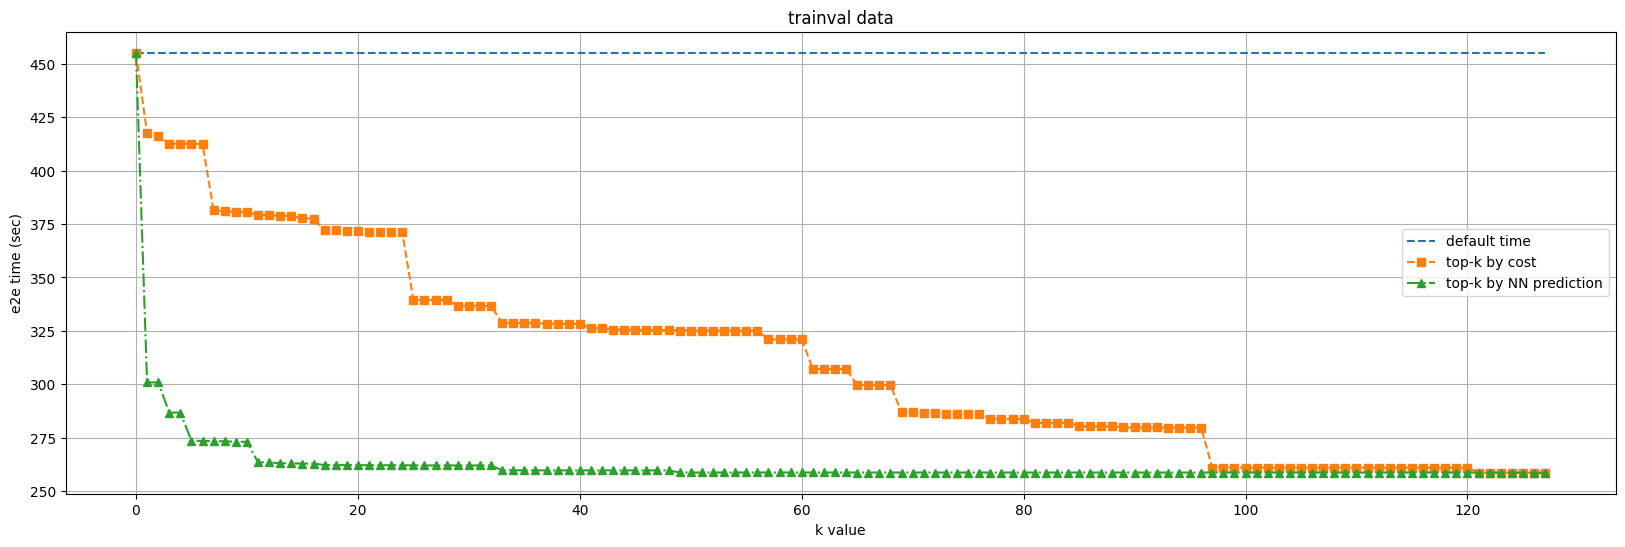

In [22]:
plot_helper(k_range, trainval_def, trainval_cost, trainval_pred, "trainval data")

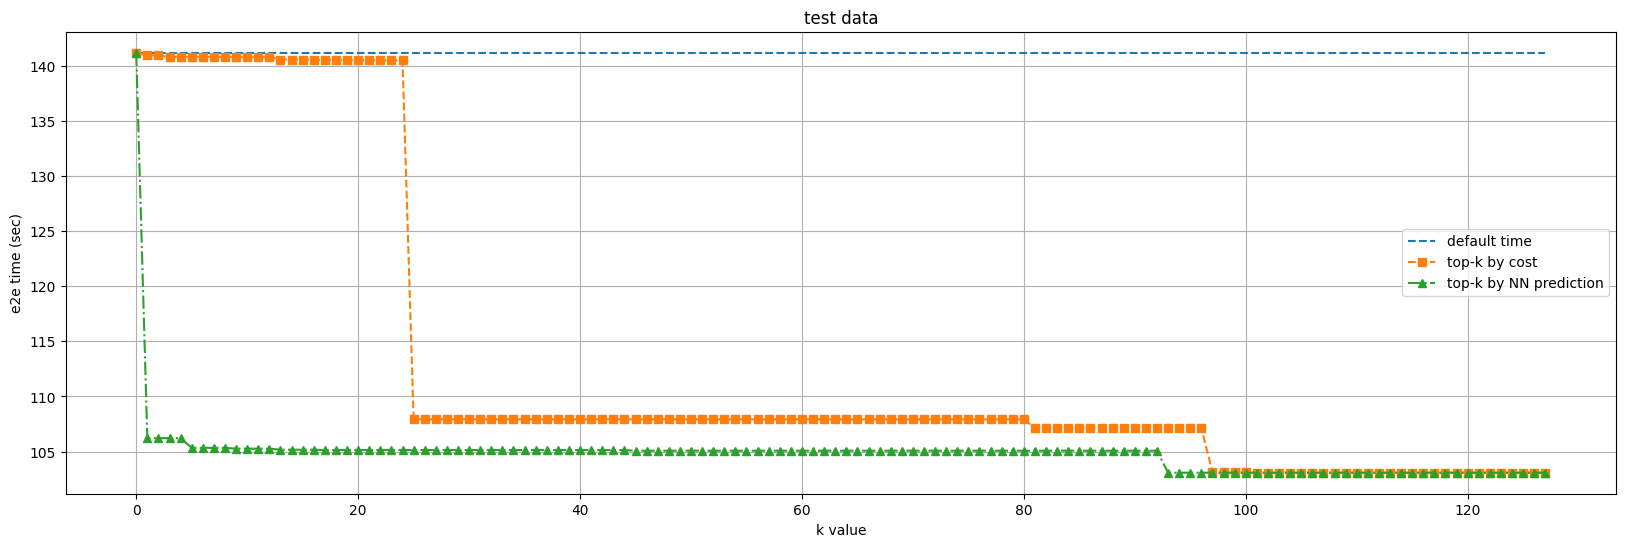

In [23]:
plot_helper(k_range, test_def, test_cost, test_pred, "test data")

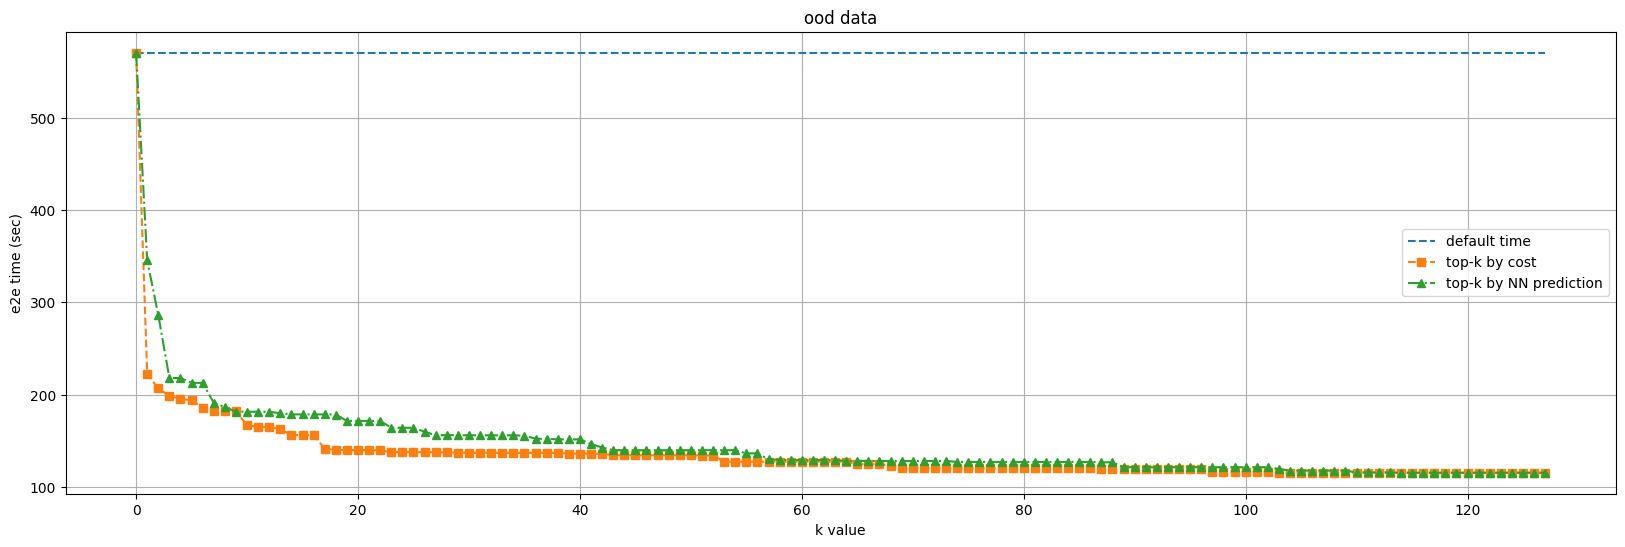

In [24]:
plot_helper(k_range, ood_def, ood_cost, ood_pred, "ood data")

We can see that on `ood` data the NN performs slightly worse than the standard cost model, but on `train`, `val` and `test` data the predictions of the model are **significantly more efficient**. This allows us to hope that when solving the regression problem, the NN predictions can be successfully used to optimise queries.